In [ ]:
#%pip install google-cloud-bigquery
#%pip install db-dtypes
#%pip install pandas-gbq

In [170]:
query = f"""
select uoe.* EXCEPT(`inventory_item_id`, `product_id`),
iv.id `inventory_item_id`,
iv.product_id,
iv.product_category `category`,
iv.product_brand `brand`,
iv.product_name,
CAST(iv.created_at AS DATE) `inventory_created_at`,
CAST(sold_at AS DATE) `inventory_sold_at`,
iv.cost
from
(select uo.*,
oi.id `order_items_id`,
oi.product_id,
oi.inventory_item_id,
oi.status,
oi.sale_price,
CAST(oi.created_at AS DATE) `order_created_at`,
e.session_id,
e.sequence_number,
e.user_id `login_user_id`,
CAST(e.created_at AS DATE) `sess_created_at`,
e.traffic_source `sess_traffic_source`,
e.uri,
e.event_type,
e.ip_address,
e.state `sess_state`,
e.city `sess_city`,
from
(select u.id `user_id`,
u.age,
u.gender,
u.state `account_state`,
u.city `account_city`,
u.country `account_country`,
u.latitude,
u.longitude,
u.traffic_source `account_traffic_source`,
CAST(u.created_at AS DATE) `account_created_at`,
o.order_id,
FROM `org_data.users` u
FULL OUTER JOIN `org_data.orders` o
on o.user_id=u.id) uo
FULL OUTER JOIN `org_data.order_items` oi
on oi.user_id=uo.user_id and oi.order_id=uo.order_id
FULL OUTER JOIN `org_data.events` e
on uo.user_id=e.user_id and date(e.created_at)=date(oi.created_at) and e.event_type='purchase'
where (oi.shipped_at >= oi.created_at) or (e.created_at is not null and oi.created_at is null) or (oi.created_at is null and uo.account_created_at is not null)
) uoe
FULL OUTER JOIN `org_data.inventory_items` iv
on iv.id=uoe.inventory_item_id
"""

In [171]:
import glob
from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("./looker-ecommerce-e30fc40090ce.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

# 데이터 조회 예시 쿼리문 
# FROM절 프로젝트명.데이터셋명.테이블명
query = query
check = client.query(query).to_dataframe()
check

,user_id,age,gender,account_state,account_city,account_country,latitude,longitude,account_traffic_source,account_created_at,...,sess_state,sess_city,inventory_item_id,product_id,category,brand,product_name,inventory_created_at,inventory_sold_at,cost
0,46241,46,M,Nordrhein-Westfalen,Rees,Germany,51.773356,6.420495,Search,2023-09-02,...,None,None,<NA>,<NA>,None,None,None,NaT,NaT,NaN
1,89364,20,M,Rio Grande do Sul,Guaíba,Brasil,-30.177374,-51.433661,Search,2023-04-18,...,Rio Grande do Sul,Guaíba,438558,21205,Jeans,Diesel,Diesel Men's Larkee Regular Straight Leg Jean,2021-10-29,NaT,96.030000
2,80035,35,F,Gyeonggi-do,Uijeongbuxi,South Korea,37.737364,127.066058,Search,2022-08-26,...,Gyeonggi-do,Uijeongbuxi,393098,10097,Sleep & Lounge,Intimo,Intimo Women's Silk Pant - 50005,2021-04-21,NaT,20.227199
3,96060,16,M,Miyagi,Sendai city,Japan,38.264748,140.731877,Search,2021-10-08,...,Miyagi,Sendai city,471864,17272,Fashion Hoodies & Sweatshirts,Metal Mulisha,Metal Mulisha Men's Unavailable,2021-01-17,NaT,31.992000
4,66972,38,F,Pará,null,Brasil,-8.182462,-49.512580,Search,2020-08-30,...,Pará,null,329080,14108,Accessories,Luxury Divas,Black Rhinestone Cross Jeweled Studded Belt,2022-01-21,NaT,7.893600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771590,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,57903,169,Tops & Tees,Ralph Lauren,Ralph Lauren Sport Women Lightweight Pony Logo...,2023-10-31,2023-12-10,19.892971
2771591,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,331399,714,Tops & Tees,Ralph Lauren,Ralph Lauren Sport Women's Oxford Dress Shirt ...,2020-12-04,2020-12-04,49.225000
2771592,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,224379,331,Tops & Tees,Ralph Lauren,Ralph Lauren Women The Skinny Polo Pony Logo T...,2022-10-21,NaT,31.434761
2771593,<NA>,<NA>,None,None,None,None,NaN,NaN,None,NaT,...,None,None,98537,73,Tops & Tees,Splendid,Splendid Women's Colorblock Tank,2022-01-22,NaT,49.456000


In [172]:
check.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771595 entries, 0 to 2771594
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   user_id                 112960 non-null   Int64  
 1   age                     112960 non-null   Int64  
 2   gender                  112960 non-null   object 
 3   account_state           112960 non-null   object 
 4   account_city            112960 non-null   object 
 5   account_country         112960 non-null   object 
 6   latitude                112960 non-null   float64
 7   longitude               112960 non-null   float64
 8   account_traffic_source  112960 non-null   object 
 9   account_created_at      112960 non-null   dbdate 
 10  order_id                93004 non-null    Int64  
 11  order_items_id          93004 non-null    Int64  
 12  status                  93004 non-null    object 
 13  sale_price              93004 non-null    float64
 14  or

In [173]:
#check.to_csv('./looker.csv', index=False)

In [174]:
df = check.copy()

카이 제곱 검정
- 신규 유저 (실험군) vs 기존 유저 (대조군)
1. 개인 정보: 성별, 연령대, 국가, 유입경로, `→ same` @하늘
    - 구매 전환율 (1번 이상 결제), retention (2번 이상 결제) `→ diff` @영아
2. 구매 상품: product_id, category, brand, … `→ same` @지은
    - top 3

In [193]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

In [175]:
# 형변환
def convert_type(df):
    for col in df.columns:
        if '_at' in col:    # 시간 데이터
            df = df.assign(**{col:pd.to_datetime(df[col])})
            print('[+] {0:<30} >>> datetime'.format(col))
        elif '_id' in col:  # id 컬럼 -> obj형으로
            df = df.assign(**{col:df[col].astype('object')})
            print('[+] {0:<30} >>> object'.format(col))
    return df

In [176]:
df = convert_type(df)

[+] user_id                        >>> object
[+] account_created_at             >>> datetime
[+] order_id                       >>> object
[+] order_items_id                 >>> object
[+] order_created_at               >>> datetime
[+] session_id                     >>> object
[+] login_user_id                  >>> object
[+] sess_created_at                >>> datetime
[+] inventory_item_id              >>> object
[+] product_id                     >>> object
[+] inventory_created_at           >>> datetime
[+] inventory_sold_at              >>> datetime


In [177]:
df.groupby('account_created_at').agg({'user_id':'nunique'}).tail(10).style.background_gradient()

,user_id
account_created_at,
2024-01-07 00:00:00,37
2024-01-08 00:00:00,31
2024-01-09 00:00:00,41
2024-01-10 00:00:00,35
2024-01-11 00:00:00,331
2024-01-12 00:00:00,364
2024-01-13 00:00:00,368
2024-01-14 00:00:00,345
2024-01-15 00:00:00,363


In [178]:
# 실험군: 2024 신규 유입 유저
treatment = df[df.account_created_at >= '2024-01-11'].copy()

In [ ]:
# 대조군: 기존 유저
#control = df[df.account_created_at.dt.year==2023].copy()   # 2023년 가입 유저
control = df[df.account_created_at < '2024-01-11'].copy()

In [180]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771595 entries, 0 to 2771594
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   user_id                 112960 non-null   object        
 1   age                     112960 non-null   Int64         
 2   gender                  112960 non-null   object        
 3   account_state           112960 non-null   object        
 4   account_city            112960 non-null   object        
 5   account_country         112960 non-null   object        
 6   latitude                112960 non-null   float64       
 7   longitude               112960 non-null   float64       
 8   account_traffic_source  112960 non-null   object        
 9   account_created_at      112960 non-null   datetime64[ns]
 10  order_id                93004 non-null    object        
 11  order_items_id          93004 non-null    object        
 12  status        

In [389]:
print(
    f'전체 유저 수 : {df.user_id.nunique(dropna=True)}명\n\
실험군 (treatment) : {treatment.user_id.nunique()}명\n\
대조군 (control) : {control.user_id.nunique()}명'
    )

전체 유저 수 : 75608명
실험군 (treatment) : 2108명
대조군 (control) : 73500명


In [214]:
chk_order = df.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()

<Axes: ylabel='Frequency'>

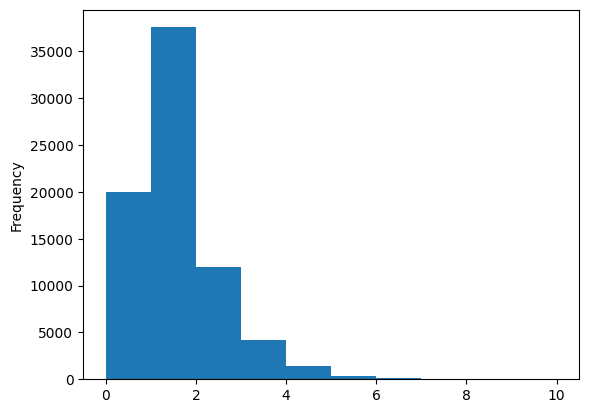

In [232]:
chk_order['order_items_id'].plot.hist()

In [216]:
chk_order_test = treatment.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()
chk_order_control = control.groupby('user_id').agg({'order_items_id':'nunique'}).reset_index()

In [217]:
test_order_0 = len(chk_order_test[chk_order_test.order_items_id == 0])
test_order_purchase = len(chk_order_test[chk_order_test.order_items_id != 0])
test_order_repurchase = len(chk_order_test[chk_order_test.order_items_id > 1])

In [218]:
control_order_0 = len(chk_order_control[chk_order_control.order_items_id == 0])
control_order_purchase = len(chk_order_control[chk_order_control.order_items_id != 0])
control_order_repurchase = len(chk_order_control[chk_order_control.order_items_id > 1])

### 구매율

In [390]:
## Part1. Chi-square Test Report
purchase = [test_order_purchase, control_order_purchase] # A와 B의 구매한 유저 수
non_purchase = [test_order_0, control_order_0]  # A와 B의 구매 안 한 유저 수
 
## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([purchase, non_purchase], columns=['treatment', 'control'], index=['purchase', 'non_purchase'])
 
## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = chi2_contingency([purchase, non_purchase])
 
## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['purchase', 'non_purchase'])
 
print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )


  
[Chi-square Analysis Result Report]
Chi-square: 0.12
P-value: 0.72
--------------------------
Expected Values
                treatment       control
purchase      1548.171322  10677.828678
non_purchase   559.828678   3861.171322
--------------------------
Observed Values
              treatment  control
purchase           1541    10685
non_purchase        567     3854
 


In [391]:
# 실험군
1541 / (1541 + 567)

0.7310246679316889

In [392]:
# 대조군
54111 / (54111 + 19389)

0.736204081632653

P-value가 0.72로 0.05보다 크다 -> 두 그룹의 차이가 없다... => 심지어 구매전환율이 기존유저가 좀 더 크다....?

### 재구매율

In [393]:
## Part1. Chi-square Test Report
purchase = [test_order_purchase, control_order_purchase] # A와 B의 구매한 유저 수
repurchase = [test_order_repurchase, control_order_repurchase]  # A와 B의 재구매한 유저 수
 
## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([purchase, repurchase], columns=['treatment', 'control'], index=['purchase', 'repurchase'])
 
## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = chi2_contingency([purchase, repurchase])
 
## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['purchase', 'repurchase'])
 
print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )


  
[Chi-square Analysis Result Report]
Chi-square: 1.12
P-value: 0.29
--------------------------
Expected Values
              treatment       control
purchase    1560.733718  10665.266282
repurchase   499.266282   3411.733718
--------------------------
Observed Values
            treatment  control
purchase         1541    10685
repurchase        519     3392
 


In [223]:
519 / (1541 + 519)

0.2519417475728155

In [224]:
17550 / (17550 + 54111)

0.24490308536023778

P-value가 0.29로 0.05보다 크다 -> 두 그룹의 차이가 없다... => 재구매율은 신규 유저가 좀 더 크다

### 지불 금액

In [394]:
chk_total_purchase = df.groupby('user_id').agg({'sale_price':'sum'}).reset_index()

<Axes: ylabel='Frequency'>

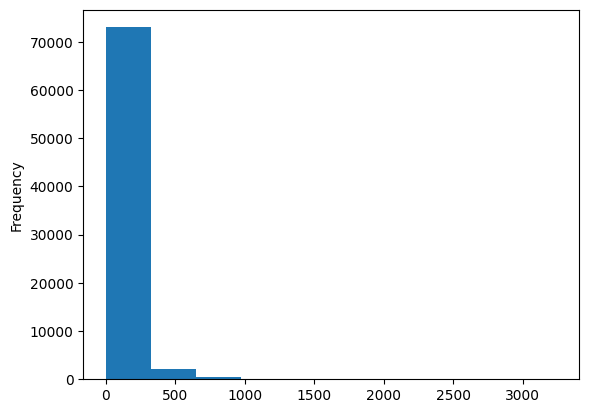

In [395]:
chk_total_purchase['sale_price'].plot.hist()

In [396]:
print(
    '전체 유저의 평균 지불 금액: 중앙값 {:.2f} | 평균값 {:.2f}'.format(
        np.median(chk_total_purchase['sale_price']), 
        np.mean(chk_total_purchase['sale_price']))
)

전체 유저의 평균 지불 금액: 중앙값 36.99 | 평균값 73.62


In [397]:
print(
    '1인당 평균 지불 금액: 실험군 ${:.2f} vs 대조군 ${:.2f}'.format(
        np.mean(treatment.groupby('user_id').agg({'sale_price':'sum'})), 
        np.mean(control.groupby('user_id').agg({'sale_price':'sum'})))
)

1인당 평균 지불 금액: 실험군 $121.20 vs 대조군 $72.26


In [398]:
print(
    '제품단가: 중앙값 {:.2f} | 평균값 {:.2f}'.format(
        np.nanmedian(df.groupby('product_name').agg({'sale_price':'mean'})), 
        np.mean(df.groupby('product_name').agg({'sale_price':'mean'})))
)

제품단가: 중앙값 39.99 | 평균값 59.63


#### 지불금액이 2024년 1월의 평균 ARPPU (56.85)를 넘는 유저

In [399]:
chk_total_purchase_test = treatment.groupby('user_id').agg({'sale_price':'sum'}).reset_index()
chk_total_purchase_control = control.groupby('user_id').agg({'sale_price':'sum'}).reset_index()

In [400]:
test_arppu = len(chk_total_purchase_test[chk_total_purchase_test.sale_price > 56.85])
control_arppu = len(chk_total_purchase_control[chk_total_purchase_control.sale_price > 56.85])

## Part1. Chi-square Test Report
over_arppu = [test_arppu, control_arppu] # A와 B의 24년 1월 arppu보다 더 지불한 유저 수
less_arppu = [len(chk_total_purchase_test) - test_order_repurchase, 
              len(chk_total_purchase_control) - control_order_repurchase]  # A와 B의 24년 1월 arppu보다 적게 지불한 유저 수
 
## Part2. Contingency Table & Chi-squaure Model
## 기초 테이블 형성
cont_table = pd.DataFrame([over_arppu, less_arppu], columns=['treatment', 'control'], index=['over_arppu', 'less_arppu'])
 
## Part3. 카이제곱 독립성 검정 모델 선언
chi2, p_val, d_f, expected = chi2_contingency([over_arppu, repurchase])
 
## 기대값 표 형성
ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = ['over_arppu', 'less_arppu'])
 
print(  '  '
 , '[Chi-square Analysis Result Report]'
 , 'Chi-square: {}'.format(round(chi2, 2))
 , 'P-value: {}'.format(round(p_val, 2))
 , '--------------------------'
 , 'Expected Values'
 , ex
 , '--------------------------'
 , 'Observed Values'
 , cont_table
 , '=========================='
 , ' '
 
 , sep = '\n'
 )


  
[Chi-square Analysis Result Report]
Chi-square: 847.44
P-value: 0.0
--------------------------
Expected Values
              treatment       control
over_arppu  1243.830943  27343.169057
less_arppu   170.169057   3740.830943
--------------------------
Observed Values
            treatment  control
over_arppu        895    27692
less_arppu       1589    70108
 


P-value가 0.0로 0.05보다 작다 -> 두 그룹의 차이가 있다 => 신규 유저의 1인당 지불금액이 더 크다

### 특정 product 구매 비율
- 2024년 1월 11일부터 판매량이 많은 제품 top 5
- 이 제품을 구매한 유저 수 vs 구매 안한 유저 수

In [401]:
product_top5 = df[df.order_created_at >= '2024-01-11'].product_name.value_counts()[:5].index

In [415]:
print('[Chi-square Analysis Result Report]\n------------------------------------')
for i,product in enumerate(product_top5, start=1):

    test = treatment[treatment.product_name==product].user_id.nunique()
    ctrl = control[control.product_name==product].user_id.nunique()

    ## Part1. Chi-square Test Report
    purchase_product = [test, ctrl] # A와 B의 특정 product를 구매한 유저 수
    unpurchase_product = [treatment.user_id.nunique() - test, 
                control.user_id.nunique() - ctrl]  # A와 B의 특정 product를 구매하지 않은 유저 수
    
    ## Part2. Contingency Table & Chi-squaure Model
    ## 기초 테이블 형성
    cont_table = pd.DataFrame([purchase_product, unpurchase_product], columns=['treatment', 'control'], index=[f'purchase_{product}', f'unpurchase_{product}'])

    ## Part3. 카이제곱 독립성 검정 모델 선언
    chi2, p_val, _, _ = chi2_contingency([purchase_product, unpurchase_product])

    ## 기대값 표 형성
    ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = [f'purchase_{product}', f'unpurchase_{product}'])

    print(
      'Product {}: {}'.format(i, product)
    , 'Chi-square: {}'.format(round(chi2, 2))
    , 'P-value: {}'.format(round(p_val, 2))
    , '--------------------------'
    , 'Expected Values'
    , ex
    , '--------------------------'
    , 'Observed Values'
    , cont_table
    ,  '=========================='
    , sep = '\n'
    )

[Chi-square Analysis Result Report]
------------------------------------
Product 1: 2 PC. Ladies Lace Babydoll Set - One Size - Black/Pink
Chi-square: 52.62
P-value: 0.0
--------------------------
Expected Values
                                                      treatment       control
purchase_2 PC. Ladies Lace Babydoll Set - One S...  1243.830943  27343.169057
unpurchase_2 PC. Ladies Lace Babydoll Set - One...   170.169057   3740.830943
--------------------------
Observed Values
                                                    treatment  control
purchase_2 PC. Ladies Lace Babydoll Set - One S...          3        1
unpurchase_2 PC. Ladies Lace Babydoll Set - One...       2105    73499
Product 2: Woman Within Plus Size Jean relaxed fit with 5-pocket styling
Chi-square: 7.52
P-value: 0.01
--------------------------
Expected Values
                                                      treatment       control
purchase_Woman Within Plus Size Jean relaxed fi...  1243.830943  27343.1

In [416]:
category_top5 = df[df.order_created_at >= '2024-01-11'].category.value_counts()[:5].index
print('[Chi-square Analysis Result Report]\n------------------------------------')
for i, category in enumerate(category_top5, start=1):

    test = treatment[treatment.category==category].user_id.nunique()
    ctrl = control[control.category==category].user_id.nunique()

    ## Part1. Chi-square Test Report
    purchase_category = [test, ctrl] # A와 B의 특정 product를 구매한 유저 수
    unpurchase_category = [treatment.user_id.nunique() - test, 
                control.user_id.nunique() - ctrl]  # A와 B의 특정 product를 구매하지 않은 유저 수
    
    ## Part2. Contingency Table & Chi-squaure Model
    ## 기초 테이블 형성
    cont_table = pd.DataFrame([purchase_category, unpurchase_category], columns=['treatment', 'control'], index=[f'purchase_{category}', f'unpurchase_{category}'])

    ## Part3. 카이제곱 독립성 검정 모델 선언
    chi2, p_val, _, _ = chi2_contingency([purchase_category, unpurchase_category])

    ## 기대값 표 형성
    ex = pd.DataFrame(expected, columns = ['treatment', 'control'], index = [f'purchase_{category}', f'unpurchase_{category}'])

    print(
      'Product {}: {}'.format(i, product)
    , 'Chi-square: {}'.format(round(chi2, 2))
    , 'P-value: {}'.format(round(p_val, 2))
    , '--------------------------'
    , 'Expected Values'
    , ex
    , '--------------------------'
    , 'Observed Values'
    , cont_table
    ,  '=========================='
    , sep = '\n'
    )

[Chi-square Analysis Result Report]
------------------------------------
Product 1: Browning Mens Goose Down Jacket
Chi-square: 1.5
P-value: 0.22
--------------------------
Expected Values
                        treatment       control
purchase_Intimates    1243.830943  27343.169057
unpurchase_Intimates   170.169057   3740.830943
--------------------------
Observed Values
                      treatment  control
purchase_Intimates          175     5558
unpurchase_Intimates       1933    67942
Product 2: Browning Mens Goose Down Jacket
Chi-square: 2.54
P-value: 0.11
--------------------------
Expected Values
                                            treatment       control
purchase_Fashion Hoodies & Sweatshirts    1243.830943  27343.169057
unpurchase_Fashion Hoodies & Sweatshirts   170.169057   3740.830943
--------------------------
Observed Values
                                          treatment  control
purchase_Fashion Hoodies & Sweatshirts          165     5078
unpurchase_Fash